In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.train import AdamOptimizer
import math

clean_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

class Titanic_Experiment:
    
    def __init__(self, parameters):
        self.experiment_name = parameters['experiment_name']
        self.train, self.test = self.clean_data(parameters['train_data'], parameters['test_data'])
        self.scale_features(parameters)
     
    def clean_data(self, train_df, test_df):
        # Calculate Mean of Values to fill missing

        age_mean = pd.concat([train_df['Age'], test_df['Age']], ignore_index=True).mean()
        fare_mean = pd.concat([train_df['Fare'], test_df['Fare']], ignore_index=True).mean()
        
        # Copy only selected features with the Survived field into the training dataset
        train = train_df[['Survived'] + clean_features].copy()
        
        # Map Gender to binary integer valuesf
        train['Sex'] = train['Sex'].map({'male': 1, 'female': 0}).astype(int)
        
        # Fill missing values with mean
        train['Age'] = train['Age'].fillna(age_mean)
        train['Fare'] = train['Fare'].fillna(fare_mean)
        
        # Drop all records with missing values 
        train = train.dropna()
        
        # Map Embarked Locations to integer values
        train['Embarked'] = train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
        
        # Copy Selected features into the test dataframe
        test = test_df[clean_features].copy()
        
        # Map Gender to binary integer values
        test['Sex'] = test['Sex'].map({'male': 1, 'female': 0}).astype(int)
        # Fill missing values with mean
        test['Age'] = test['Age'].fillna(age_mean)
        test['Fare'] = test['Fare'].fillna(fare_mean)
        test['Embarked'] = test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

        return train, test
    
    def scale_features(self, parameters):
        def get_mean(data_list):
            return pd.concat(data_list, ignore_index=True).mean()

        def get_std(data_list):
            return pd.concat(data_list, ignore_index=True).std()

        def get_min(data_list):
            return pd.concat(data_list, ignore_index=True).min()

        def get_max(data_list):
            return pd.concat(data_list, ignore_index=True).max()

        for feature in parameters['selected_features']:
            if parameters['feature_scaling'] == 'rescaling':
                data_list = [self.train[feature], self.test[feature]]
                min_ = get_min(data_list)
                max_ = get_max(data_list)
                self.train[feature] = (self.train[feature] - min_) / (max_ - min_)
                self.test[feature] = (self.test[feature] - min_) / (max_ - min_)
            elif parameters['feature_scaling'] == 'mean_normalization':
                data_list = [self.train[feature], self.test[feature]]
                mean = get_mean(data_list)
                min_ = get_min(data_list)
                max_ = get_max(data_list)
                self.train[feature] = (self.train[feature] - mean) / (max_ - min_)
                self.test[feature] = (self.test[feature] - mean) / (max_ - min_)
            else:
                data_list = [self.train[feature], self.test[feature]]
                mean = get_mean(data_list)
                std = get_std(data_list)
                self.train[feature] = (self.train[feature] - mean) / std
                self.test[feature] = (self.test[feature] - mean) / std

    def batch_data(self, X, Y, mini_batch_size = 64, seed = 0):
        """
        Creates a list of random minibatches from (X, Y)

        Arguments:
        X -- input data, of shape (input size, number of examples)
        Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
        mini_batch_size -- size of the mini-batches, integer

        Returns:
        mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
        """

        np.random.seed(seed)            # To make your "random" minibatches the same as ours
        m = X.shape[0]                  # number of training examples
        mini_batches = []

        # Step 1: Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_Y = Y[permutation, :].reshape((m,1))

        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[k * mini_batch_size : (k + 1) * mini_batch_size, :]
            mini_batch_Y = shuffled_Y[k * mini_batch_size : (k + 1) * mini_batch_size, :]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:

            mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:, :]
            mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:, :]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches
    
    def build_model(self, parameters):
        layers_dim = parameters['layers_dim']
        num_feature = len(parameters['selected_features'])
        learning_rate = parameters['learning_rate']
        
        with tf.name_scope('fc'):
            X = tf.placeholder(tf.float32, [None, num_feature], name='x')
            Y = tf.placeholder(tf.float32, [None, 1], name='labels')
            fc = tf.contrib.layers.stack(X, tf.contrib.layers.fully_connected, layers_dim)
            hypothesis = tf.contrib.layers.fully_connected(fc, 1, activation_fn=None)
        
        with tf.name_scope('Cost'):
            loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=hypothesis, labels=Y)
            cost = tf.reduce_mean(loss)
            cost_summary = tf.summary.scalar('cost', cost)
        
        with tf.name_scope('train'):
            train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
            
            
        with tf.name_scope('Accuracy'):
            prediction = tf.round(tf.sigmoid(hypothesis))
            correct_prediction = tf.equal(prediction, Y)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            tf.summary.scalar('accuracy', accuracy)
        
        merged = tf.summary.merge_all()
        model = {'X': X, 'Y': Y, 'hypothesis': hypothesis, 'cost': cost,
                 'train_op': train_op, 'prediction': prediction, 'accuracy': accuracy, 
                 'summary': merged, 'cost_summary': cost_summary}

        return model
    
    def train_model(self, parameters, model):
        num_epochs = parameters['num_epochs']
        minibatch_size = parameters['minibatch_size']
        train_size = self.train_X.shape[0]
        saver = tf.train.Saver()
        epoch_list = []
        cost_list = []
        
        merged_summary = tf.summary.merge_all()
        writer = tf.summary.FileWriter(parameters['model_name'])
        with tf.Session() as sess:
            init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
            sess.run(init_op)
            for epoch in range(num_epochs):
                epoch_cost = 0.
                num_minibatches = int(train_size / minibatch_size)
                minibatches = self.batch_data(self.train_X, self.train_Y, minibatch_size)
                for minibatch in minibatches:
                    (minibatch_X, minibatch_Y) = minibatch
                    feed_dict = {model['X'] : minibatch_X, model['Y'] : minibatch_Y}
                    _ ,minibatch_cost = sess.run([model['train_op'], model['cost']], feed_dict= feed_dict)
                    epoch_cost += minibatch_cost / num_minibatches                             
                    cs = model['cost_summary'].eval(feed_dict)
                    #s = sess.run(model['summary'], feed_dict=feed_dict)
                    #writer.add_summary(s, epoch)
                    writer.add_summary(cs, epoch)
                if parameters['print'] and (epoch % parameters['print_freq'] == 0):

                    
                    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                if parameters['save_cost'] and (epoch % parameters['save_cost_freq'] == 0):
                    epoch_list.append(epoch)
                    cost_list.append(epoch_cost)
            saver.save(sess, parameters['model_name'])
        return {'epoch_list': epoch_list, 'cost_list' : cost_list}
    
    def evaluate(self, parameters, model):
        saver = tf.train.Saver()
        with tf.Session() as sess:
            init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
            sess.run(init_op)
            saver.restore(sess, parameters['model_name'])
            print ("Train Accuracy:", model['accuracy'].eval({model['X']: self.train_X, model['Y']: self.train_Y}))
            print ("Valid Accuracy:", model['accuracy'].eval({model['X']: self.valid_X, model['Y']: self.valid_Y}))

    def predict(self,parameters, model):
        saver = tf.train.Saver()
        with tf.Session() as sess:
            init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
            sess.run(init_op)
            saver.restore(sess, parameters['model_name']) 
            return model['prediction'].eval({model['X']: self.test_X})
    
    def run(self, parameters):
        m = int(self.train.values.shape[0] * 0.7)
        self.train_X = self.train[parameters['selected_features']].values[:m, :]
        self.train_Y = self.train['Survived'].values.reshape(-1, 1)[:m, :]
        self.valid_X = self.train[parameters['selected_features']].values[m:, :]
        self.valid_Y = self.train['Survived'].values.reshape(-1, 1)[m:, :]
        self.test_X = self.test[parameters['selected_features']].values
        
        with tf.Graph().as_default():
            model = self.build_model(parameters)
            plot_data = self.train_model(parameters, model)
        
        %matplotlib inline
        print
        if parameters['save_cost']:
            plt.plot(plot_data['epoch_list'], plot_data['cost_list'])

        
        with tf.Graph().as_default() as graph:
            model = self.build_model(parameters)
            self.evaluate(parameters, model)
            #writer = tf.summary.FileWriter(logdir=parameters['model_name'], graph=graph)
            
        answer = pd.DataFrame(test_df['PassengerId'], columns=['PassengerId'])
        with tf.Graph().as_default():
            model = self.build_model(parameters)
            self.test_Y = self.predict(parameters, model)
            answer['Survived'] = self.test_Y.astype(int)
        answer.to_csv(f"predictions/{self.experiment_name}.csv", index=False)
        
        


In [32]:
'''
DataFrame Columns
[ 
    'PassengerId', 
    'Survived',
    'Pclass',
    'Name',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Ticket',
    'Fare',
    'Cabin',
    'Embarked'
]
    
'''
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# Parameters
parameters = {
    'experiment_name': "",
    'selected_features': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'],
    'feature_scaling': 'standardization',
    'test_data': test_df,
    'train_data': train_df,
    'layers_dim': [14],
    'learning_rate': 0.01,
    'steps': 10,
    'num_epochs': 300,
    'minibatch_size': 16,
    'model_name': './models/titanic_root',
    'target': 'Survived',
    'print': True,
    'print_freq': 100,
    'save_cost': True,
    'save_cost_freq': 10
}







Cost after epoch 0: 0.639895
Cost after epoch 100: 0.526332
Cost after epoch 200: 0.526294
INFO:tensorflow:Restoring parameters from ./models/gender_only/model
Train Accuracy: 0.7893891
Valid Accuracy: 0.7790262
INFO:tensorflow:Restoring parameters from ./models/gender_only/model


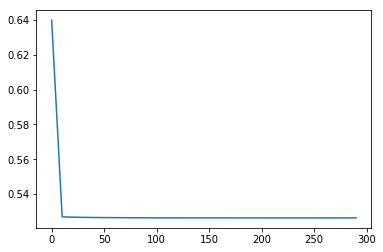

In [33]:
# Gender Only
p_Gender = parameters
p_Gender['experiment_name'] = 'gender_only'
p_Gender['selected_features'] = ['Sex']
p_Gender['model_name'] = './models/gender_only/model'
p_Gender['num_epochs'] = 300
exp = Titanic_Experiment(p_Gender)
exp.run(p_Gender)

Cost after epoch 0: 0.571589
Cost after epoch 100: 0.462570
Cost after epoch 200: 0.455317
Cost after epoch 300: 0.453017
INFO:tensorflow:Restoring parameters from ./models/gender_wealth/model
Train Accuracy: 0.7990354
Valid Accuracy: 0.81273407
INFO:tensorflow:Restoring parameters from ./models/gender_wealth/model


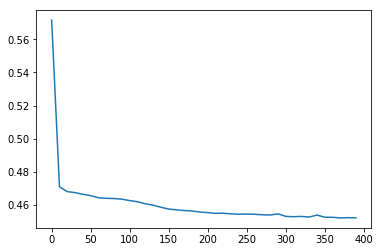

In [4]:
# Gender + Socioeconomic status
p_Gender_Wealth = parameters
p_Gender_Wealth['experiment_name'] = 'gender_wealth'
p_Gender_Wealth['selected_features'] = ['Sex', 'Pclass', 'Fare']
p_Gender_Wealth['model_name'] = './models/gender_wealth/model'
p_Gender_Wealth['num_epochs'] = 400
exp = Titanic_Experiment(p_Gender_Wealth)
exp.run(p_Gender_Wealth)

Cost after epoch 0: 0.602668
Cost after epoch 100: 0.420151
Cost after epoch 200: 0.412198
Cost after epoch 300: 0.406718
Cost after epoch 400: 0.403291
Cost after epoch 500: 0.401662
Cost after epoch 600: 0.400024
Cost after epoch 700: 0.397189
Cost after epoch 800: 0.398358
Cost after epoch 900: 0.395852
Cost after epoch 1000: 0.395846
Cost after epoch 1100: 0.395499
INFO:tensorflow:Restoring parameters from ./models/gender_wealth_age/model
Train Accuracy: 0.8392283
Valid Accuracy: 0.8164794
INFO:tensorflow:Restoring parameters from ./models/gender_wealth_age/model


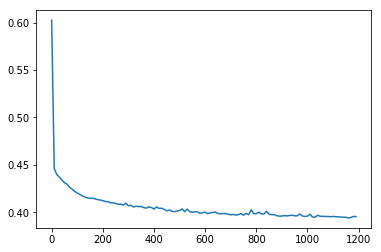

In [5]:
# Gender Socioeconomic status Age
p_Gender_Wealth_Age = parameters
p_Gender_Wealth_Age['experiment_name'] = 'gender_wealth_age'
p_Gender_Wealth_Age['selected_features'] = ['Sex', 'Pclass', 'Fare', 'Age']
p_Gender_Wealth_Age['model_name'] = './models/gender_wealth_age/model'
p_Gender_Wealth_Age['num_epochs'] = 1200
exp = Titanic_Experiment(p_Gender_Wealth_Age)
exp.run(p_Gender_Wealth_Age)